# Predicting Hunger
6.4.2020

In [56]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
import pipeline
import importlib
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# for reloading the pipeline if neccesary...
importlib.reload(pipeline)

<module 'pipeline' from '/Users/matthewmauer/ML/project/pipeline.py'>

## Load and Clean the Data

In [4]:
data = pipeline.read('create_targets/total_data_with_targets.csv')
data.sample(10)

There are 14068 rows and 27 columns in the data set.


,ADMIN0,ADMIN1,Unnamed: 2,ADMIN0.1,ADMIN1.1,month,year,CS,tmin_mm,tmax_mm,...,battle_fatal,protest_fatal,riot_fatal,explosion_fatal,violence_on_civs_fatal,Retail,pop,CS_in_1_month,CS_in_2_months,CS_in_3_months
7027,Somalia,Mudug,3763,Somalia,Mudug,4.0,2013.0,2.50,NaN,NaN,...,1.0,0.0,0.0,0.0,4.0,-0.565834,NaN,NaN,NaN,2.333333
424,Ethiopia,Dire Dawa,4517,Ethiopia,Dire Dawa,8.0,2009.0,NaN,212.631579,357.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,396000.0,NaN,2.5,NaN
8238,South Sudan,Northern Bahr el Ghazal,1218,South Sudan,Northern Bahr el Ghazal,7.0,2009.0,2.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,844000.0,NaN,NaN,2.000000
11382,Tanzania,Dar es Salaam,3967,Tanzania,Dar es Salaam,10.0,2010.0,1.00,210.733333,326.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
14032,Uganda,Western,1547,Uganda,Western,6.0,2017.0,1.00,NaN,NaN,...,0.0,0.0,0.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN
8615,South Sudan,Warrap,1331,South Sudan,Warrap,4.0,2013.0,2.25,NaN,NaN,...,16.0,0.0,0.0,0.0,9.0,NaN,NaN,NaN,NaN,2.000000
13837,Uganda,Northern,8995,Uganda,Northern,5.0,2009.0,NaN,NaN,NaN,...,17.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2.0,NaN
8410,South Sudan,Unity,9965,South Sudan,Unity,8.0,2017.0,NaN,NaN,NaN,...,20.0,0.0,0.0,0.0,4.0,NaN,867000.0,NaN,2.5,NaN
3692,Kenya,Nairobi,5151,Kenya,Nairobi,3.0,2014.0,NaN,151.714286,279.227273,...,1.0,0.0,1.0,6.0,0.0,NaN,3863000.0,1.5,NaN,NaN
6689,Somalia,Lower Shabelle,9219,Somalia,Lower Shabelle,5.0,2018.0,NaN,NaN,NaN,...,27.0,0.0,0.0,77.0,14.0,-1.683792,NaN,2.0,NaN,NaN


In [5]:
data = pipeline.clean_events(data)

# 3-Month Predictions
## Grid Search using Nest Time Series Cross Validation

In [6]:
data.columns.values

array(['ADMIN0', 'ADMIN1', 'Unnamed: 2', 'ADMIN0.1', 'ADMIN1.1', 'month',
       'year', 'CS', 'tmin_mm', 'tmax_mm', 'tavg_mm', 'prcp_mm',
       'battle_cnt', 'protest_cnt', 'riot_cnt', 'explosion_cnt',
       'violence_on_civs_cnt', 'battle_fatal', 'protest_fatal',
       'riot_fatal', 'explosion_fatal', 'violence_on_civs_fatal',
       'Retail', 'pop', 'CS_in_1_month', 'CS_in_2_months',
       'CS_in_3_months'], dtype=object)

In [7]:
# subset data to those with thre month predictions
data3m = data.dropna(axis=0, subset=['CS_in_3_months'])

In [ ]:
models = {
    'KernelRidgeRegression': KernelRidge(),
    'Random Forest': RandomForestRegressor(random_state=30254)
}

learner = pipeline.LongitudinalLearner(models)
learner.train_test_split(data3m)
learner.inputs_outputs(features = ['tmin_mm', 'tmax_mm', 'tavg_mm', 'prcp_mm',
       'battle_cnt', 'protest_cnt', 'riot_cnt', 'explosion_cnt',
       'violence_on_civs_cnt', 'battle_fatal', 'protest_fatal',
       'riot_fatal', 'explosion_fatal', 'violence_on_civs_fatal',
       'Retail', 'pop'],
                    target = 'CS_in_3_months',
                    dirty_features = ['tmin_mm', 'tmax_mm', 'tavg_mm', 'prcp_mm',
                                      'Retail', 'pop'])

In [ ]:
GRID = {
    'KernelRidgeRegression': [{'kernel': x, 'alpha': y, 'gamma': z} 
                              for x in ('linear', 'poly', 'rbf') \
                              for y in (0.01, 0.1, 1, 10, 100) \
                              for z in (0.01, 0.1, 1, 10, 100)
                             ],
    'Random Forest': [{'criterion':x, 'max_depth':y, 'n_estimators':z, 'min_samples_split':w}
                      for x in ('mse', 'mae') \
                      for y in (1, 3, 5) \
                      for z in (100, 1000, 5000) \
                      for w in (2, 10)]
}

# learner.grid_search(GRID=GRID)

## Grid Search using Group Cross Validation

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

Rename repeat Admin1 regions — just 'Northern'.

In [10]:
def convert_northern(row):
    if row['ADMIN1'] == 'Northern':
        row['ADMIN1'] = '%s (%s)' % (row['ADMIN1'], row['ADMIN0'])
    return row

In [11]:
data3m = data3m.apply(convert_northern, axis=1)

In [12]:
data3m.ADMIN1.value_counts()

Bakool             37
Dire Dawa          37
Awdal              37
Lower Juba         37
Woqooyi Galbeed    37
                   ..
Singida             7
Shinyanga           7
Manyara             7
Rukwa               7
Njombe              7
Name: ADMIN1, Length: 133, dtype: int64

Subset data.

In [14]:
mask = data3m.year < 2018
train = data3m[mask]
test = data3m[~mask]

In [16]:
features = ['tmin_mm', 'tmax_mm', 'tavg_mm', 'prcp_mm',
       'battle_cnt', 'protest_cnt', 'riot_cnt', 'explosion_cnt',
       'violence_on_civs_cnt', 'battle_fatal', 'protest_fatal',
       'riot_fatal', 'explosion_fatal', 'violence_on_civs_fatal',
       'Retail', 'pop']

target = 'CS_in_3_months'

Xtrain = train[features]
Xtest = test[features]
Ytrain = train[target]
Ytest = test[target]

### Kernel Ridge Regression

In [ ]:
krr = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('krr', KernelRidge(solver='svd', kernel='poly'))
])


In [26]:
krr = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('krr', KernelRidge())
])

# krr = Pipeline(SimpleImputer(strategy='median'), KernelRidge())

params = {
    'krr__kernel': ('linear', 'poly', 'rbf'), 
    'krr__alpha': (0.01, 0.1, 1, 10, 100), 
    'krr__gamma': (0.01, 0.1, 1, 10, 100)
} 

scores = {
          'mse': make_scorer(mean_squared_error),
          'mae': make_scorer(mean_absolute_error),
         }

gcv = GroupKFold()

krr_grid_model = GridSearchCV(estimator=krr, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='mse',
                          iid=True)

krr_grid_results = krr_grid_model.fit(Xtrain, Ytrain, groups=train['ADMIN1'])

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warn

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warn

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warn

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warn

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warn

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warn

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.76199e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matr

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.54252e-17): result may not be accurate.
  dual_coef

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.54252e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.59973e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.03854e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.71382e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/matthewmauer/anaconda3/envs/m

In [31]:
krr_scores = pd.DataFrame(krr_grid_results.cv_results_)
results = krr_scores[['param_krr__kernel', 'param_krr__alpha', 'param_krr__gamma',
            'mean_test_mse', 'mean_test_mae']]
results

,param_krr__kernel,param_krr__alpha,param_krr__gamma,mean_test_mse,mean_test_mae
0,linear,0.01,0.01,0.412747,0.510545
1,poly,0.01,0.01,690.927463,4.509057
2,rbf,0.01,0.01,2.556882,1.445819
3,linear,0.01,0.1,0.412747,0.510545
4,poly,0.01,0.1,601.505381,4.369096
...,...,...,...,...,...
70,poly,100,10,668.655394,4.529568
71,rbf,100,10,3.593037,1.789509
72,linear,100,100,0.402501,0.503131
73,poly,100,100,736.445832,4.685751


In [33]:
results.sort_values(by='mean_test_mse').head(10)

,param_krr__kernel,param_krr__alpha,param_krr__gamma,mean_test_mse,mean_test_mae
72,linear,100,100,0.402501,0.503131
69,linear,100,10,0.402501,0.503131
60,linear,100,0.01,0.402501,0.503131
63,linear,100,0.1,0.402501,0.503131
66,linear,100,1,0.402501,0.503131
24,linear,0.1,10,0.403999,0.503744
27,linear,0.1,100,0.403999,0.503744
21,linear,0.1,1,0.403999,0.503744
18,linear,0.1,0.1,0.403999,0.503744
15,linear,0.1,0.01,0.403999,0.503744


It appears that the __heavily regularized, linear regession__ performed best. And the linear ridge regression performed far better than the RBF or polynomial regression.

In [49]:
best_krr = krr_grid_results.best_estimator_
pipeline.model_eval(best_krr, Xtest, Ytest)

MSE: 3.983853225661135
MAE: 1.8868680996862468


### Random Forest Regression

In [38]:
forest = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('forest', RandomForestRegressor(random_state=30254))
])

params = {
    'forest__criterion': ('mse', 'mae'),
    'forest__max_depth': (1, 3, 5), 
    'forest__n_estimators': (10, 100, 1000), 
    'forest__min_samples_split': (2, 10)
}

scores = {
          'mse': make_scorer(mean_squared_error),
          'mae': make_scorer(mean_absolute_error),
         }

gcv = GroupKFold()

forest_grid_model = GridSearchCV(estimator=forest, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='mse',
                          iid=True)

forest_grid_results = forest_grid_model.fit(Xtrain, Ytrain, groups=train['ADMIN1'])

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [40]:
forest_scores = pd.DataFrame(forest_grid_results.cv_results_)
results = forest_scores[['param_forest__criterion', 'param_forest__max_depth', 
                         'param_forest__n_estimators', 'param_forest__min_samples_split',
                        'mean_test_mse', 'mean_test_mae']]
results

,param_forest__criterion,param_forest__max_depth,param_forest__n_estimators,param_forest__min_samples_split,mean_test_mse,mean_test_mae
0,mse,1,10,2,0.350199,0.470987
1,mse,1,100,2,0.350519,0.471096
2,mse,1,1000,2,0.350555,0.471240
3,mse,1,10,10,0.350199,0.470987
4,mse,1,100,10,0.350519,0.471096
5,mse,1,1000,10,0.350555,0.471240
6,mse,3,10,2,0.333200,0.449883
7,mse,3,100,2,0.331290,0.448282
8,mse,3,1000,2,0.332352,0.448476
9,mse,3,10,10,0.333217,0.449874


In [51]:
best_forest = forest_grid_results.best_estimator_
pipeline.model_eval(best_forest, Xtest, Ytest)

MSE: 0.35437933806948446
MAE: 0.4938266719430154


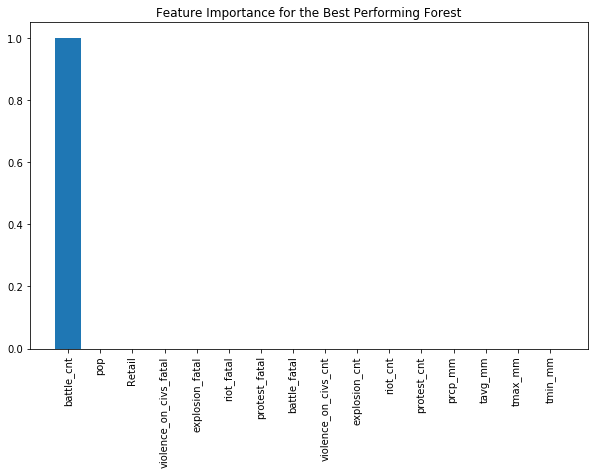

In [57]:
# Get feature importances
importances = best_forest.named_steps['forest'].feature_importances_

# Sort in descending order
indices = np.argsort(importances)[::-1]

# Sort the labels in a corresponding fashion
labels = Xtrain.columns.values
names = [labels[i] for i in indices]

# Plot
plt.figure(figsize=[10,6])
plt.title('Feature Importance for the Best Performing Forest')
plt.bar(range(Xtrain.shape[1]), importances[indices])
plt.xticks(range(Xtrain.shape[1]), names, rotation=90)
plt.show()